# Single-event global correlogram

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/tsonpham/ObsSeisHUS2025/blob/master/Day4/D4_Prac.ipynb)

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), April 2025

---
## What we do in this notebook

Global correlation wavefield is an emerging concept in global seismology. It refers to the mathematical manifestication of the seismic wavefield. Here the seemingly noisy records (3-10 hours) after large earthquakes are turned into clear signals that are sensitive to the deep Earth's interiors.

- Learn about mathematical cross-correlation of digital seismographs
- Step-by-step processing to calculate seismic cross-correlation functions at the global scale
- First step to handle large amount of seismic data

In [1]:
# Environemtal setup (uncomment if running in colab)

!pip install obspy numpy==1.26.4 cartopy

In [2]:
#@title Setting notebook resolution
#@markdown Run this cell for better figure resolution

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Data preparation and preprocessing

This notebook is designed to be inclusive starting from fetching raw seismic waveforms from IRIS Data Management Center. The next cell defines three functions to
1. acquire event metadata from the International Seismological Center (ISC) earthquake bulletin using unique event ID,
2. fetch raw seismic data of the vertical component in a designed time window with respect to the event origin,
3. apply simple data processing procedure to the fetched data.

The functions make use of several `Obspy` functionalities introduced in previous modules. The cell must be excecuted, but its content can be skipped as matter of time.

In [3]:
#@title Definition of helper functions
#@markdown Helper function to download and process seismic data from IRIS

from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from pathlib import Path
from obspy import read_events, read_inventory, read
from obspy.geodetics import locations2degrees
import pickle

def get_event(isc_eventid):
    """
    Download the event information from ISC and return the event object.
    Parameters
    ----------
    isc_eventid : str
        The ISC event ID of the event to download.
    Returns
    -------
    event : obspy.core.event.Event
        The event object containing the event information.
    """
    # file name for the event information
    fname = Path(f'ISC.{isc_eventid}.xml')
    # Download the event information from ISC if not already downloaded
    if not fname.exists():
        event = Client('ISC').get_events(eventid=isc_eventid, filename=fname)
    # Read the event information from the file
    event = read_events(fname)[0]
    return event

def get_waveform_data(event_origin, network='_GSN', channel='LHZ', window_start=10e3, window_end=35e3,
        loc_priorities = ['', '00', '10'], with_inv=False):
    '''
    Download the waveform data from IRIS for a given event and return the stream object.
    Parameters
    ----------
    event_origin : obspy.core.event.Origin
        The event origin object containing the event information.
    network : str
        The network code to download the waveform data from.
    channel : str
        The channel code to download the waveform data from.
    window_start : float
        The start time of the window to download the waveform data from.
    window_end : float
        The end time of the window to download the waveform data from.
    loc_priorities : list of str
        The location codes to download the waveform data from.
    Returns
    -------
    dstream : obspy.core.stream.Stream
        The stream object containing the waveform data.
    '''
    eventtime = event_origin.time
    evla = event_origin.latitude
    evlo = event_origin.longitude
    # Fearch for all stations in the _GNS network recording in the time window
    inv_fname = Path(network+eventtime.strftime('.%Y%m%d.staxml'))
    # Download the station information from IRIS unless already downloaded
    if not inv_fname.exists():
        Client().get_stations(network=network, channel=channel, starttime=eventtime,
                              endtime=eventtime+24*3600, level='channel', filename=inv_fname)
    # Read the station information from the file
    inv = read_inventory(inv_fname)

    # For each station, add a line to the bulk request depending on their location code
    # and the location code with the highest priority
    # The location codes are sorted by priority
    bulk = []
    for net in inv:
        for sta in net:
            loc_codes = [cha.location_code for cha in sta.channels]
            if len(set(loc_priorities) & set(loc_codes)) == 0: continue
            # get the location code with the highest priority
            for loccode in loc_priorities:
                if loccode in loc_codes: break
            # add the bulk entry
            bulk.append((net.code, sta.code, loccode, channel,
                # the time window is padded by 2,500 seconds at both ends to for quality assurance
                eventtime+window_start-2.5e3, eventtime+window_end+2.5e3))

    # Download the waveforms from IRIS if not already downloaded
    pkl_fname = Path(network+eventtime.strftime('.%Y%m%d.pkl'))
    if not pkl_fname.exists():
        print (f'Requesting waveforms for {len(bulk)} individual {channel} channels ...')
        dstream = Client().get_waveforms_bulk(bulk, longestonly=True, minimumlength=7*3600)
        # Append metadata to header
        for tr in dstream:
            tmp = inv.select(network=tr.stats.network, station=tr.stats.station)[0][0]
            tr.stats.update({'stla': tmp.latitude, 'stlo': tmp.longitude,
                'distance': locations2degrees(evla, evlo, tmp.latitude, tmp.longitude)*111.195e3})
        with open(pkl_fname, 'wb') as f: pickle.dump(dstream, f)
    else:
        # print ('Reading waveforms ...')
        with open(pkl_fname, 'rb') as f: dstream = pickle.load(f)
    if with_inv:
        return dstream, inv
    else:
        return dstream

def data_processing(dstream, channel, evtime, window_start, window_end):
    '''
    Process the waveform data by resampling, detrending, tapering, and trimming.
    Parameters
    ----------
    dstream : obspy.core.stream.Stream
        The stream object containing the waveform data.
    channel : str
        The channel code to process.
    evtime : obspy.core.UTCDateTime
        The event origin time.
    window_start : float
        The start time of the window to process the waveform data from.
    window_end : float
        The end time of the window to process the waveform data from.
    Returns
    -------
    dstream1 : obspy.core.stream.Stream
        The processed stream object containing the waveform data.
    '''
    # Create a copy of the stream object
    dstream1 = dstream.copy()
    # Downsample the data to 1 Hz if the channel is not LHZ
    if channel != 'LHZ': dstream1.resample(1.0)
    # Remove the linear trend and taper the data with a cosine taper
    dstream1.detrend('linear')
    dstream1.taper(max_percentage=0.01, type='cosine')
    # Trim the data to the time window and pad with zeros
    dstream1.trim(evtime+window_start, evtime+window_end, pad=True, fill_value=0)
    return dstream1

We call the helper function in the next cell to download `LHZ` component, sampled at 1 Hz, from all stations belonging to the [*Global Seismograph Network*](https://www.usgs.gov/programs/earthquake-hazards/gsn-global-seismographic-network). These state-of-the-art seismometers continuously monitor the global ground motion with data telecommunicated to data centers in real time.

"*The Global Seismographic Network is a permanent digital network of state-of-the-art seismological and geophysical sensors connected by a telecommunications network, serving as a multi-use scientific facility and societal resource for monitoring, research, and education.*"

Preparing data for Event ID: 611831635
   Network: _GSN
   Channel: LHZ sampled at 1.0 Hz
   Time window from origin to 35000.0 seconds
Requesting waveforms for 140 individual LHZ channels ...
   Number of retrieved waveforms 128


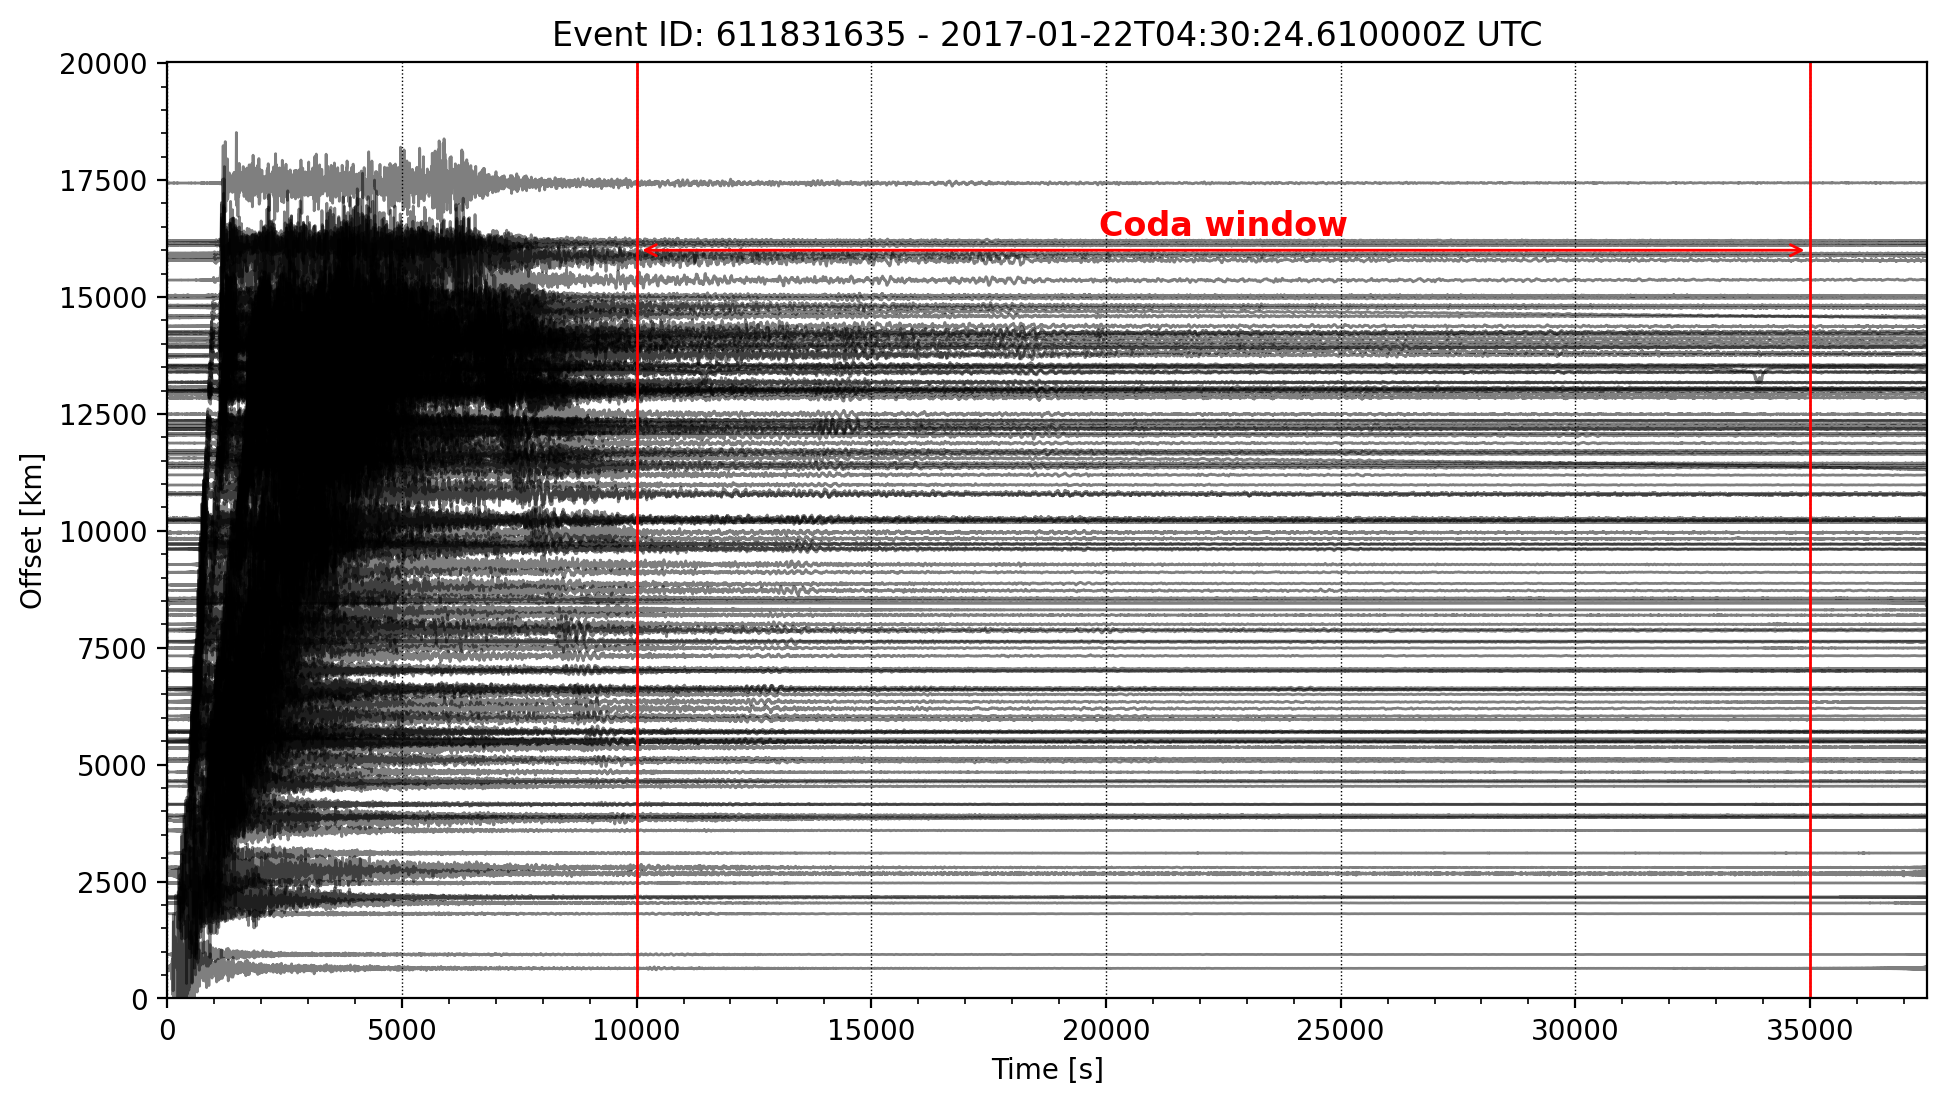

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


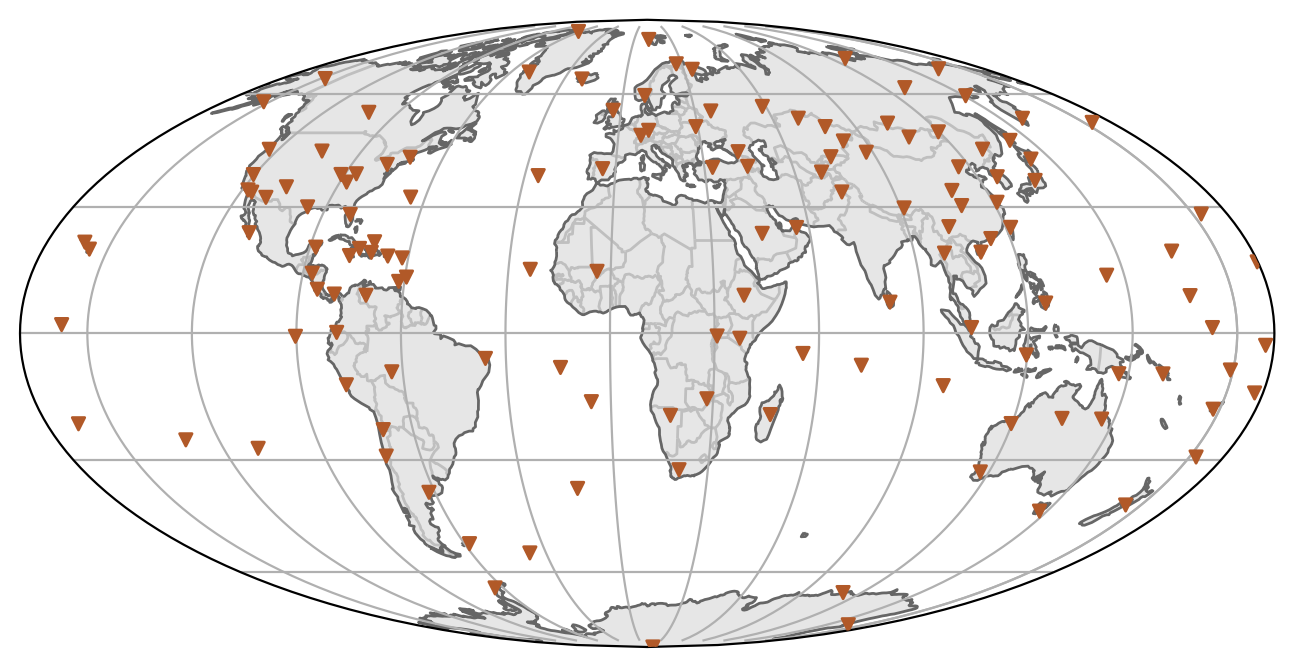

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the event ID, network, channel, and time window
isc_eventid = '611831635'
network = '_GSN'
channel = 'LHZ'
window_start = 10e3
window_end = 35e3
sampling_rate = 1.0 # Hz by default because we are using LHZ
npts = int((window_end-window_start)/sampling_rate) # number of samples in the time window

print (f'Preparing data for Event ID: {isc_eventid}')
print (f'   Network: {network}')
print (f'   Channel: {channel} sampled at {sampling_rate} Hz')
print (f'   Time window from origin to {window_end} seconds')

# fetch event metadata using ISC event ID,
event = get_event(isc_eventid)
# download the waveforms from IRIS unless they existed locally
dstream, inv = get_waveform_data(event.preferred_origin(), network, channel, 0, window_end, with_inv=True)
print (f'   Number of retrieved waveforms {len(dstream)}')

# plot waveform gather for visual inspection
fig = plt.figure(figsize=(10, 6))
for tr in dstream:
    tr.data = tr.data / np.max(np.abs(tr.data)) # normalize the data
dstream.plot(type='section', orientation='horizontal', color='black', fig=fig, starttime=event.preferred_origin().time, scale=20)
fig.gca().set_title(f'Event ID: {isc_eventid} - {event.preferred_origin().time} UTC', fontsize=12)
fig.gca().axvline(window_start, color='red', linestyle='-', lw=1)
fig.gca().axvline(window_end, color='red', linestyle='-', lw=1)
fig.gca().annotate('', xy=(window_start, 16e3), xytext=(window_end, 16e3), arrowprops=dict(arrowstyle='<->', lw=1, color='red'))
fig.gca().annotate('Coda window', xy=(.5*(window_start+window_end), 16.3e3), color='red', fontsize=12, fontweight='bold', ha='center')
fig.gca().set(ylim=(0, 180*111.195))

# plot the station map distribution
inv.plot(label=False, size=20)
plt.show()

# do some simple data processing: trim the waveform at desired time window and resample 1 Hz
dstream = data_processing(dstream, channel, event.preferred_origin().time, window_start, window_end)

First, we use the unique event identifier [611831635](https://isc.ac.uk/cgi-bin/web-db-run?event_id=611831635&out_format=ISF2&request=COMPREHENSIVE) to get an event metadata from the [ISC](https://isc.ac.uk/iscbulletin/search/bulletin/) bulletin.

The virtual network code `_GSN` (see complete list [here](https://earthquake.usgs.gov/monitoring/operations/network.php?virtual_network=GSN)) is used to include qualifying stations being parts of in several regional networks.

Vertical, long period component seismograms `LHZ`, by default sampled at 1 `Hz`, are suitable to balance between computational expense and spectral resolution.

Phạm et al. (2018) used the waveform window from 10,000 to 35,000 seconds (roughly 3 to 10 hours) after large earthquakes to compute the global correlograms.

---
## Single station processing

It has been demonstrated above that the cross-correlation function can be computed efficiently in the spectral domain. This is especially important when computing CCF for an array of many stations using long seismic records.

In practice, temporal and spectral normalizations are crucial in extracting clear signals in the cross-correlogram.

- Because the level of seismic energy generally decays with time, *temporal normalization* is needed to balance the contribution of high amplitude data early in the coda record.

- Spectral normalization balances the contribution of signals at different frequency in the interested frequency band. Generally long-period signals are more energetic than shorter period signals because the former ones are dissipated quicklier when propagating through the Earth.

Following defines the temporal and spectral normalization operators using the same running absolute mean weights.

### Temporal normalization

We use an adaptive weighting function to to balance amplitude-decaying amplitudes. Phạm et al. (2018) used the running-absolute-mean [Bensen et al., 2007] as for the weight in the time domain as

\begin{equation}
\hat{x}_n = \frac{x_n} {\frac{1}{2N + 1} \sum_{j=n-N}^{n+N} |x_j|}.
\end{equation}

The number of averaging points $N$ in the denominator is alternatively refered as the temporal normalization width $\Delta W = 2 N \Delta T$, where $\Delta T$ is the discrete sampling interval of the input seismogram.

Phạm et al. (2018) empirically used $2N\Delta T = 128$ seconds in their work. They also pre-filtered the seismogram before calculating the weight. However, the discussion on the role of the pre-filtering step is beyond the scope of this notebook. We refer to the orignial article and there-in reference to Bensen et al. (2007) for more details.

In [5]:
from obspy import Trace, Stream

def running_absolute_mean_normalization(input_tr, width, filter_kw=None, return_weight=False):
    """
    Apply running absolute mean normalization to a waveform/spectral trace.
    :param trace: ObsPy Trace object
    :param fband: frequency band for the filter / None if no pre-filtering is applied to the weight
    :param width: width of the running absolute mean normalization window in seconds or Hz depending on the input_tr
    :return: output_tr trace
    """
    if type(input_tr) is not Trace:
        raise TypeError('Input trace is not an ObsPy Trace object.')
    # pre-filter the weight trace if frequency filter band is given
    weight_tr = input_tr.copy()
    output_tr = input_tr.copy()
    if type(input_tr.data[0]) is np.complex128 or type(input_tr.data[0]) is np.complex64:
        delta = input_tr.stats.delta_f
    else:
        delta = input_tr.stats.delta
    # if pre-filtering is indicated, apply the filter to the weight trace
    if filter_kw is not None: weight_tr.filter(**filter_kw)
    # calculate the normalizing weight by running absolute mean
    winlen = 2 * int(0.5 * width / delta) + 1
    avg_mask = np.ones(winlen) / winlen
    weight = np.convolve(np.abs(weight_tr.data), avg_mask, 'same')
    # divide the orignal data by the smoothed weight
    mask = (weight > 1e-8*np.max(weight))
    output_tr.data[mask] = input_tr.data[mask] / weight[mask]
    output_tr.data[np.logical_not(mask)] = 0
    # return the output_tr trace
    if return_weight:
        return output_tr, weight
    else:
        return output_tr

Let's demonstrate the running absolute mean temporal normalization on a real coda seismogram.

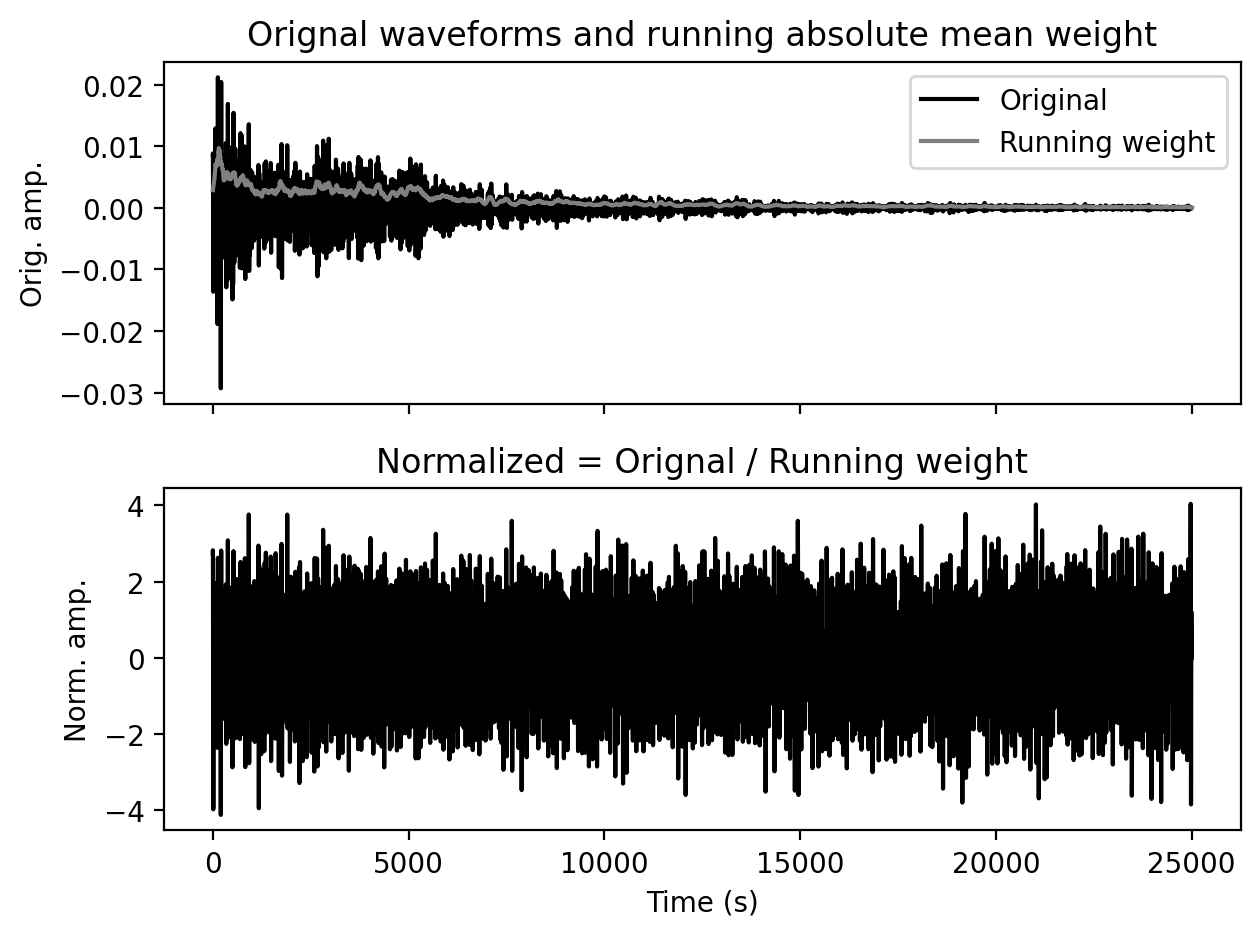

In [6]:
# Temporal normalization parameters
temp_width = 128 #seconds
filter_kw = dict(type='bandpass', freqmin=0.02, freqmax=0.067, corners=4, zerophase=True) # bandpass filter between 15 to 50 seconds

# Seismogram before temporal normalization
input_tr = dstream[0].copy() # an example trace
orig = input_tr.copy().filter(**filter_kw)

# Seismogram after temporal normalization
output_tr, weight = running_absolute_mean_normalization(input_tr, temp_width, filter_kw, True)
norm = output_tr.copy().filter(**filter_kw)

# Plot the comparison
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(orig.times(), orig.data, c='k', label='Original')
ax[0].plot(norm.times(), weight, c='gray', label='Running weight')
ax[0].set(ylabel='Orig. amp.', title='Orignal waveforms and running absolute mean weight')
ax[0].legend()
ax[1].plot(norm.times(), norm.data, c='k', label='Normalized')
ax[1].set(ylabel='Norm. amp.', title='Normalized = Orignal / Running weight', xlabel='Time (s)')
fig.tight_layout()
plt.show()

### Spectral normalization

Now, the temporally normalized seismograms are Fourier transformed to the frequency domain in prepration for the fast computation of CCFs.

A similar running-absolute-mean normalization is applied to the spectral domain to balance the contribution of signals at different periods to the final CCF. The spectral normalization is defined as

\begin{equation}
\hat{s}_n = \frac{s_n} {\frac{1}{2N + 1} \sum_{j=n-N}^{n+N} |s_j|}.
\end{equation}

$s_n$ is the spectrogram of the input seismogram. The number of averaging points $N$ in the denominator is alternatively refered as the spectral normalization width $\Delta W = 2 N \Delta \omega$, where $\Delta \omega$ is the discrete frequency step $\Delta \omega = 1/L$ and $L$ is the length of the input time trace.

Phạm et al. (2018) empirically used $2N\Delta\omega = 2\times 10^{-3}$ Hz as the spectral normalization width in their work.

In [7]:
from scipy.fftpack import next_fast_len
def spectral_normalization(input_tr, npts, ram_width, return_weight=False):
    """
    Apply spectral normalization to a waveform trace.
    :param input_tr: ObsPy Trace object
    :param npts: number of points for FFT
    :param ram_width: width of the running absolute mean normalization window in seconds
    :return: output_tr trace
    """
    # get the number of points for FFT using tensorflow fft module
    fft_npts = next_fast_len(2*npts)
    # real-to-complex FFT by numpy
    spec_data = np.fft.rfft(input_tr.data, fft_npts)
    # create a spectral trace
    spec_tr = Trace(data=spec_data, header=input_tr.stats)
    spec_tr.stats.update({'npts':len(spec_data), 'delta_f':.5/((len(spec_data)-1)*input_tr.stats.delta)})
    # apply running absolute mean normalization to the spectral trace
    if ram_width is not None:
        return running_absolute_mean_normalization(spec_tr, ram_width, return_weight=return_weight)
    else:
        return spec_tr

Let's demonstrate the effect of the spectral normalization function on the already temporally normalised seismogram.

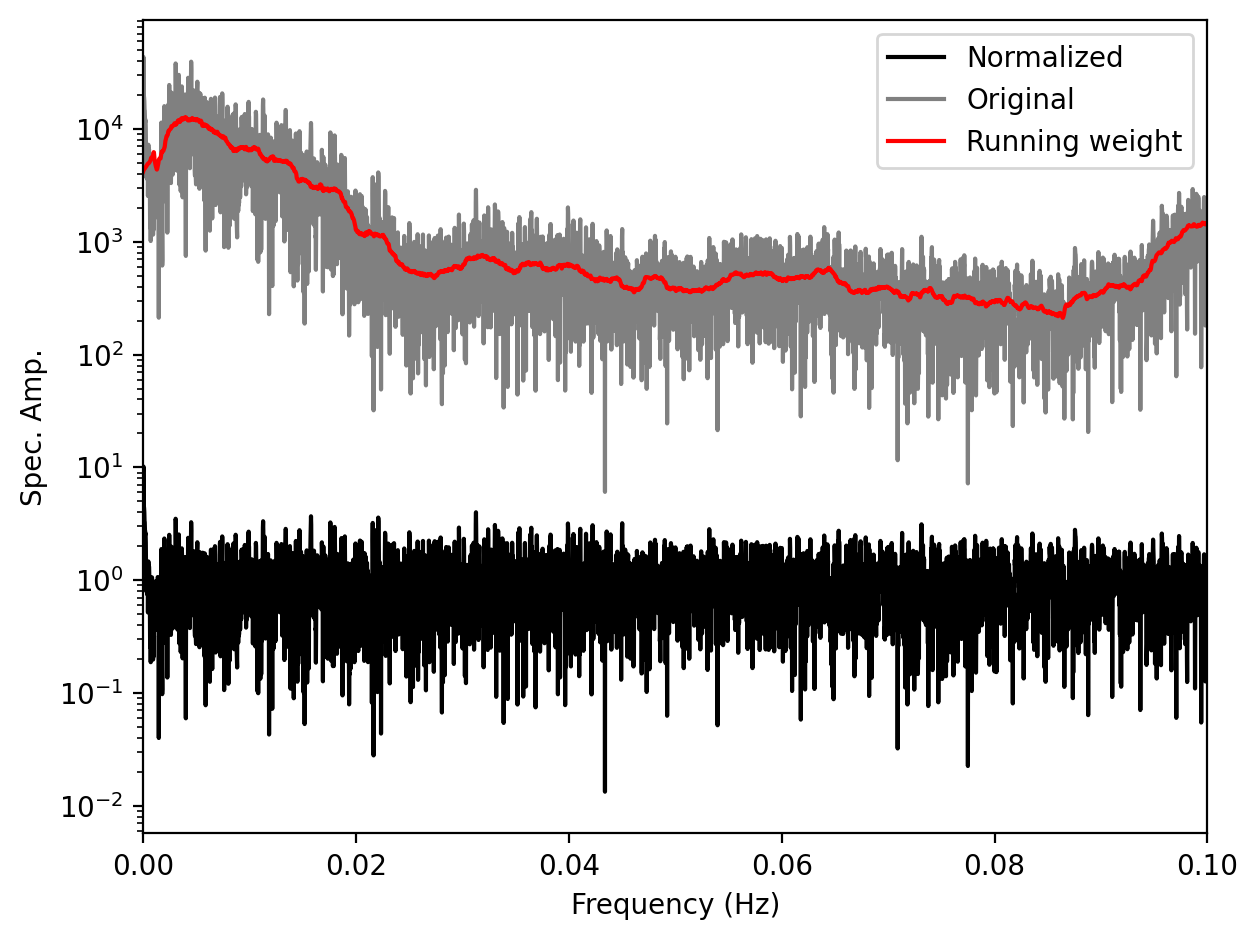

In [8]:
# Spectral normalization parameters
spec_width = 2e-3 # Hz

# apply spectral normalization to the data
spec_tr, weight = spectral_normalization(output_tr, npts, spec_width, True)

# when spec_width is None, the plain spectrum of the input trace is returned for comparison
spec_tr0 = spectral_normalization(output_tr, npts, None)

# Plot the comparison
fig, ax = plt.subplots()
freqs = np.arange(spec_tr.stats.npts) * spec_tr.stats.delta_f
ax.semilogy(freqs, np.abs(spec_tr.data), color='k', label='Normalized')
ax.semilogy(freqs, np.abs(spec_tr0.data), color='gray', label='Original')
ax.semilogy(freqs, np.abs(weight), color='r', label='Running weight')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spec. Amp.')
ax.set_xlim([0, 0.1])
ax.legend()
fig.tight_layout()
plt.show()

### Single station processing: temporal and spectral normalizations

Now we concatenate the temporal and spectral normalization operators together and apply them to all seismograms in the database.

In [9]:
def single_station_processing(dstream):
    spec_st = Stream()
    for data_tr in dstream:
        temp_tr = running_absolute_mean_normalization(data_tr, temp_width, filter_kw)
        spec_tr = spectral_normalization(temp_tr, npts, spec_width)
        spec_st.append(spec_tr)
    return spec_st

In [10]:
import time

print ('Parameterisation used in the single-station processing:')
print (f' Waveform channel: {channel}')
print (f'       Event time: {event.preferred_origin().time}')
print (f'       Window start: {event.preferred_origin().time+window_start}')
print (f'       Window end: {event.preferred_origin().time+window_end}')
print (f'       Sampling rate: {sampling_rate} Hz')
print (f' Temporal normalization: running absolute mean normalization')
print (f'       Temporal width: {temp_width} seconds')
print (f'       Weight filtering band: {filter_kw["freqmin"]} to {filter_kw["freqmax"]} Hz')
print (f' Spectral normalization: running absolute mean normalization')
print (f'       Spectral width: {spec_width} Hz')
print (f'       Number of points: {npts}')

start = time.time()
spec_st = single_station_processing(dstream)
print (f'\nSingle processing of {len(dstream)} traces took {time.time()-start:.2f} seconds')

Parameterisation used in the single-station processing:
 Waveform channel: LHZ
       Event time: 2017-01-22T04:30:24.610000Z
       Window start: 2017-01-22T07:17:04.610000Z
       Window end: 2017-01-22T14:13:44.610000Z
       Sampling rate: 1.0 Hz
 Temporal normalization: running absolute mean normalization
       Temporal width: 128 seconds
       Weight filtering band: 0.02 to 0.067 Hz
 Spectral normalization: running absolute mean normalization
       Spectral width: 0.002 Hz
       Number of points: 25000

Single processing of 128 traces took 0.98 seconds


---
## Cross-correlation of all station pairs

We use the spectral data obtained from this step to perform cross-correlation in the frequency domain. The first task is to multiply one spectra to the conjugate of the other station. Secondly, based on the interstation distance between the two stations, add them to the bin corresponding to their distance.

However, the practical challenge is there are a large number of spectral multiplications to excecute. As the number of operations is $O (N^2)$. The main rationale of the implementation in the cell below is to speed up that process using multithreading and vectorized operations.

In [11]:
from obspy.geodetics import locations2degrees
from concurrent.futures import ThreadPoolExecutor
import threading

def xcorr_stack(spec_st, dist_bins, max_tlag, ncores=2, fname=None):
    '''
    Cross-correlation stacking of the spectral traces in frequency domain
    Parameters
    ----------
    spec_st : obspy.core.stream.Stream
        The stream object containing the spectral traces.
    dist_bins : list of float
        The distance bins to stack the cross-correlation function.
    max_tlag : float
        The maximum time lag to stack the cross-correlation function.
    ncores : int or None
        The number of cores to use for parallel processing. If None, use all available cores.
    fname : str or None
        The file name to save the output. If None, do not save the output.
    Returns
    -------
    output : dict
        The output dictionary containing the cross-correlation function and other information.
    '''
    stlats = [tr.stats.stla for tr in spec_st]
    stlons = [tr.stats.stlo for tr in spec_st]
    spec_data = np.array([tr.data for tr in spec_st])
    # number of traces and frequency bins
    ntraces, nspec = spec_data.shape
    # number of cross-correlation distance bins
    nbins = len(dist_bins) - 1
    # global variables
    spec_xcorr_stack = np.zeros([nbins, nspec], dtype=np.complex128)
    bin_count = np.zeros(nbins, dtype=np.float32)

    # calculate all inter-receiver distances
    mlats, mlons = np.meshgrid(stlats, stlons)
    cc_gcarc = locations2degrees(mlats, mlons, mlats.T, mlons.T)
    # determine the bin index for each inter-receiver distance
    cc_inds = np.digitize(cc_gcarc, dist_bins) - 1

    # Create a lock for each bin
    # Note: the multiple locks for each bin is recommended to avoid congested
    # memory access when multiple threads are trying to access the same bin.
    locks = [threading.Lock() for _ in range(nbins)]

    # Create a ThreadPoolExecutor
    with ThreadPoolExecutor(ncores) as executor:
        # Local cross-correlation function to excecuted in multiple threads
        def cross_correlation(s1):
            # Cross-correlation function in frequency domain
            spec_xcorr = spec_data[s1] * np.conj(spec_data[s1:])
            for _, ind in enumerate(cc_inds[s1, s1:]):
                # Acquire the lock for stacking
                with locks[ind]:
                    # Bin pair cross-correlograms in frequency domain
                    spec_xcorr_stack[ind] += spec_xcorr[_]
                    # Count the trace pairs in each inter-receiver bin
                    bin_count[ind] += 1

        # Run the cross-correlation function in a separate thread
        for s1 in range(ntraces):
            executor.submit(cross_correlation, s1)

    # inverse FFT to get the cross-correlation function in time domain
    image = np.fft.irfft(spec_xcorr_stack)
    # fold the cross-correlation function and trim the time window
    nmaxlag = int(max_tlag / spec_st[0].stats.delta)
    image = 0.5 * (image + image[:, ::-1])[:, :nmaxlag]

    # output in dictionary
    correlogram = dict(bin_count=bin_count, # number of traces in each bin
                  delta_t=spec_st[0].stats.delta, # seconds
                  delta_d=dist_bins[1] - dist_bins[0], # degrees
                  interstation_dist=(dist_bins[1:]+dist_bins[:-1])/2, # seconds
                  time_lapse=np.arange(nmaxlag)*spec_st[0].stats.delta, # degrees
                  image=image) # dimensionaless of size (nbins, nmaxlag)
    # save the correlogram to a file if fname is given
    if fname is not None:
        with open(fname, 'wb') as f: pickle.dump(correlogram, f)
    return correlogram

In [12]:
dist_bins = np.linspace(0, 180, 181) # degrees
max_tlag = 7000 # seconds

# Cross-correlation stacking of the spectral traces
start = time.time()
correlogram = xcorr_stack(spec_st, dist_bins, max_tlag)
print (f'\nCross-correlation stacking took {time.time()-start:.2f} seconds')


Cross-correlation stacking took 2.88 seconds


We define the following function to display the computed correlogram.

In [13]:
def display_correlogram(correlogram_or_fname, filter_kw, ymax=4000, title=None):
    """
    Plot the cross-correlation function from the correlogram dictionary or file.
    :param correlogram_or_fname: str or dict
        The file name of the correlogram or the correlogram dictionary.
    :param filter_kw: dict
        The filter parameters for the cross-correlation function.
    :param ymax: float
        The maximum y-axis limit for the plot.
    :param title: str
        The title of the plot.
    :return: None
    """
    if type(correlogram_or_fname) is not dict:
        with open(correlogram_or_fname, 'rb') as f: correlogram = pickle.load(f)
    else:
        from copy import deepcopy
        correlogram = deepcopy(correlogram_or_fname)

    # Get info from the correlogram dictionary
    delta = correlogram['delta_t']
    bin_count = correlogram['bin_count']
    img = correlogram['image']
    time_lapse = correlogram['time_lapse']
    inter_dist = correlogram['interstation_dist']

    # Normalize the cross-correlation function by the number of traces in each bin
    from obspy.signal.filter import bandpass
    for i in range(img.shape[0]):
        if bin_count[i] == 0: continue
        img[i] = bandpass(img[i], df=1/delta, freqmin=filter_kw['freqmin'], freqmax=filter_kw['freqmax'],
                            corners=filter_kw['corners'], zerophase=filter_kw['zerophase'])
        img[i] /= bin_count[i]

    # Plot the cross-correlation function
    fig, ax = plt.subplots(2, 1, figsize=(3.5, 7), sharex=True, gridspec_kw={'height_ratios': (.2, 1.)})
    ax[0].bar(np.arange(len(bin_count)), bin_count, width=1, color='gray', edgecolor='none')
    ax[0].set(ylabel='# pairs', title=title)
    VMAX = 2.5e-2 * np.max(np.abs(img))
    ax[1].imshow(img.T, aspect='auto', vmin=-VMAX, vmax=VMAX, cmap='seismic', origin='lower',
                interpolation='sinc', extent=(0, 180, time_lapse[0], time_lapse[-1]))
    ax[1].set(ylim=(0, ymax), xlim=(0, 180),
            xlabel='Inter-station distance (degrees)', ylabel='Time lapse (seconds)')
    for x in ax: x.grid(ls='--', lw=.5, color='gray')
    fig.tight_layout()
    plt.show()

def display_correlogram_plain(correlogram_or_fname, filter_kw, ymax=4000, fname=None):
    """
    Plot the cross-correlation function from the correlogram dictionary or file.
    :param correlogram_or_fname: str or dict
        The file name of the correlogram or the correlogram dictionary.
    :param filter_kw: dict
        The filter parameters for the cross-correlation function.
    :param ymax: float
        The maximum y-axis limit for the plot.
    :param fname: str
        Filename to save the plot.
    :return: None
    """
    if type(correlogram_or_fname) is not dict:
        with open(correlogram_or_fname, 'rb') as f: correlogram = pickle.load(f)
    else:
        from copy import deepcopy
        correlogram = deepcopy(correlogram_or_fname)

    # Get info from the correlogram dictionary
    delta = correlogram['delta_t']
    bin_count = correlogram['bin_count']
    img = correlogram['image']
    time_lapse = correlogram['time_lapse']
    inter_dist = correlogram['interstation_dist']

    # Normalize the cross-correlation function by the number of traces in each bin
    from obspy.signal.filter import bandpass
    for i in range(img.shape[0]):
        if bin_count[i] == 0: continue
        img[i] = bandpass(img[i], df=1/delta, freqmin=filter_kw['freqmin'], freqmax=filter_kw['freqmax'],
                            corners=filter_kw['corners'], zerophase=filter_kw['zerophase'])
        img[i] /= bin_count[i]

    # Plot the cross-correlation function
    fig, ax = plt.subplots(figsize=(2.5, 5))
    VMAX = 2.5e-2 * np.max(np.abs(img))
    ax.imshow(img.T, aspect='auto', vmin=-VMAX, vmax=VMAX, cmap='seismic', origin='lower',
                interpolation='sinc', extent=(0, 180, time_lapse[0], time_lapse[-1]))
    ax.set(xticklabels=[], yticklabels=[], xlim=(0, 180), ylim=(0, ymax))
    ax.grid(ls='--', lw=.5, color='gray')
    fig.tight_layout()
    if fname is not None: plt.savefig(fname, dpi=300)
    plt.show()

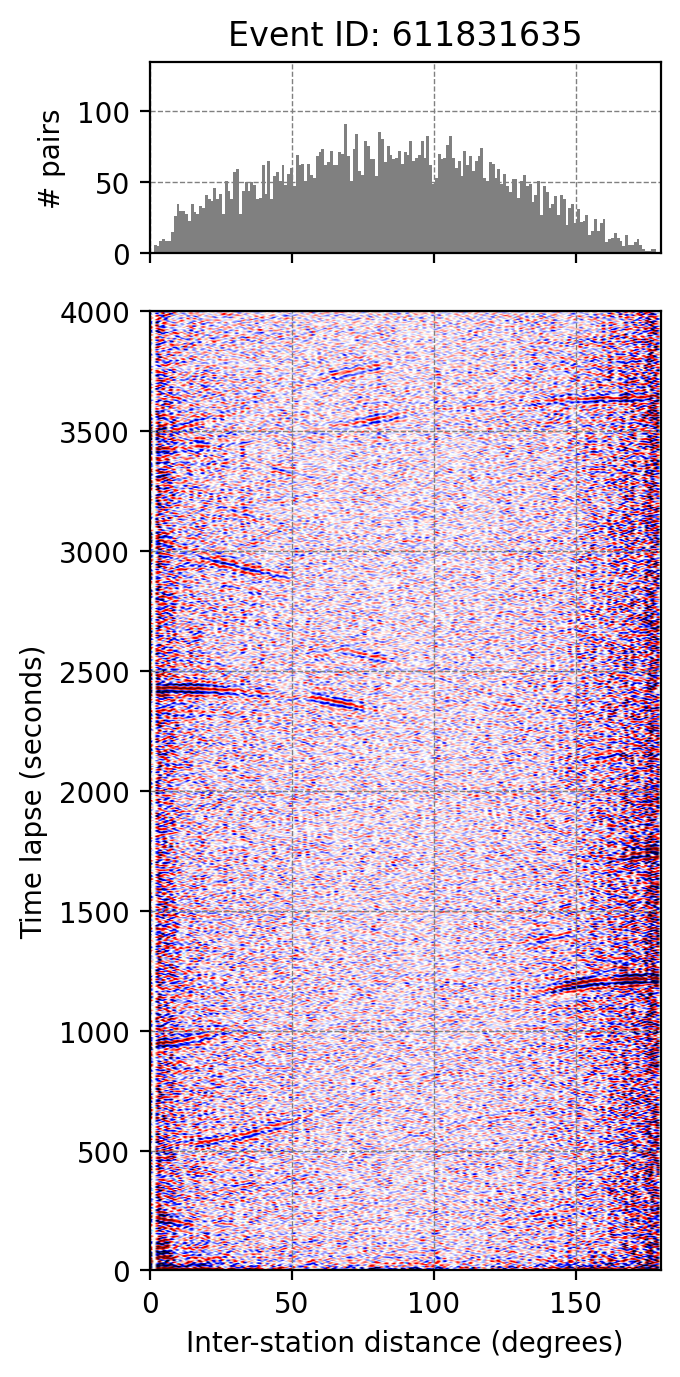

In [14]:
display_correlogram(correlogram, filter_kw, title=f'Event ID: {isc_eventid}')

The above processing has been the backbone data processing for multiple publications from the ANU Global Seismology group using the concept of the global correlation wavefield studying the deep Earth interiors, including,
- Tkalčić H., T.-S. Phạm and S. Wang, The Earth's coda correlation wavefield: Rise of the new paradigm and recent advances, Earth-Science Reviews, 208, doi:10.1016/j.earscirev.2020.103285, 2020.
- Phạm T.-S., H. Tkalčić, M. Sambridge, and B. L. N. Kennett, Earth's correlation wavefield: Late coda correlation, Geophys. Res. Lett., 45 (7),  doi:10.1002/2018GL077244, 2018.
- Tkalčić, H. and T.-S. Phạm, Shear properties of the Earth's inner core revealed by a detection of J waves in global correlation wavefield, Science, 362, doi:10.1126/science.aau7649, 2018.

---
## Challenge

### Student work

Below is the list of 12 grade A events according to Tkalčić & Phạm ([2020](https://doi.org/10.1093/gji/ggaa369)). These events were empirically found to be effective in excite clear features in the global correlogram individually.

In [15]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/tsonpham/ObsSeisHUS2025/master/Day4/GradeA_events.csv')
df

isc_eventid        date  latitude  longitude  depth  magintude  \
0      14686988  2010-05-09      3.69      96.04   41.0       7.27   
1     600191591  2010-12-21     26.88     143.78   20.0       7.50   
2     600800706  2012-03-20     16.47     -98.37   19.0       7.63   
3     601675877  2012-09-05     10.02     -85.39   21.0       7.73   
4     601768557  2012-09-30      1.91     -76.37  155.0       6.84   
5     607727143  2014-04-01    -19.96     -71.02   11.0       6.25   
6     610573069  2014-10-14     12.59     -88.07   64.0       6.58   
7     612180979  2015-10-26     36.50      70.53  204.0       7.15   
8     608079035  2015-12-04    -47.68      85.31   26.0       6.82   
9     615035032  2016-11-13    -42.67     172.92   16.0       8.03   
10    609939179  2016-12-25    -43.42     -73.92   34.0       7.71   
11    611831635  2017-01-22     -6.23     155.07  157.0       7.15   

   magnitude_type                               region  
0              MS                    Northern Sumatera  
1              MS                 Bonin Islands region  
2              MS               Near coast of Guerrero  
3              MS                           Costa Rica  
4              mb                             Colombia  
5              mb          Off coast of northern Chile  
6              mb         Off coast of central America  
7              mb                    Hindu Kush region  
8              MS               Southeast Indian Ridge  
9              MS                         South Island  
10             MS                       Southern Chile  
11             mb  Bougainville-Solomon Islands region

You are challenged to compute the individual global correlogram of one or more events from the list using their `isc_eventid`. Please copy this piece of code to the next cell and complete it with correct keywords.

```
isc_eventid = <CHANGE ME>
# Fetch the event information
event = get_event(isc_eventid)

# Download the waveforms from IRIS unless they existed locally
dstream = get_waveform_data(<CHANGE ME>, network, channel, window_start, window_end)

# Do some simple data processing: trim the waveform at desired time window and resample 1 Hz
dstream = data_processing(dstream, channel, <CHANGE ME>, window_start, window_end)

# Process single station data
spec_st = <CHANGE ME>

# Specify cross-correlation parameters
corr_fname = event.preferred_origin().time.strftime(f'XC.%Y%m%d.pkl')
xcorr_stack(spec_st, <CHANGE ME>, <CHANGE ME>, fname=corr_fname)

# Plot the cross-correlation function
display_correlogram(corr_fname, filter_kw, title=f'Event ID: {isc_eventid}')
```

Please upload your XC.????????.h5 to this shared Google Drive [directory](https://drive.google.com/drive/folders/1PP5UQ2Wyam82Db9zZxZ06cwmNTx6ZFlv?usp=drive_link). We will see how the global correlogram stacked by multiple events look like.

In [ ]:
## Enter your code here, replace <CHANGE ME> with correct code

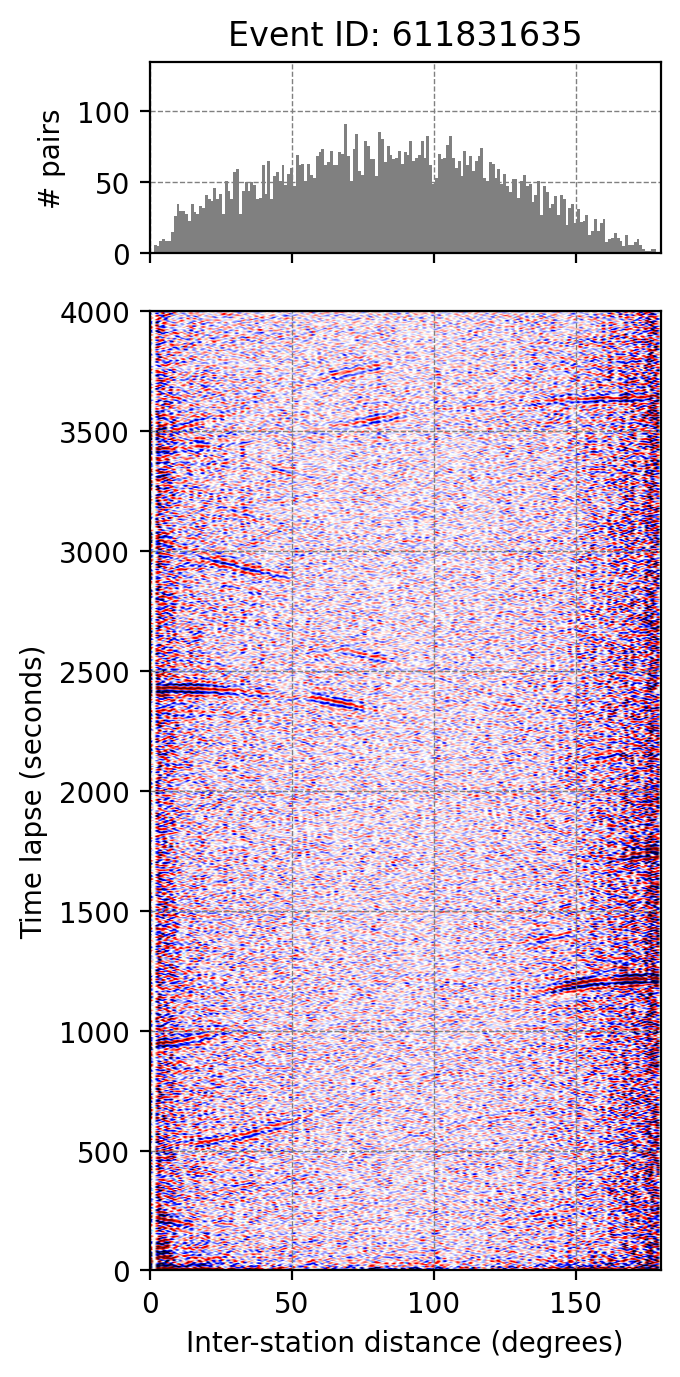

In [16]:
#@title View the solution
#@markdown Try to complete the code before running this cell.

isc_eventid = "611831635"
# Fetch the event information
event = get_event(isc_eventid)

# Download the waveforms from IRIS unless they existed locally
dstream = get_waveform_data(event.preferred_origin(), network, channel, window_start, window_end)

# Do some simple data processing: trim the waveform at desired time window and resample 1 Hz
dstream = data_processing(dstream, channel, event.preferred_origin().time, window_start, window_end)

# Process single station data
spec_st = single_station_processing(dstream)

# Specify cross-correlation parameters
corr_fname = event.preferred_origin().time.strftime(f'XC.%Y%m%d.pkl')
xcorr_stack(spec_st, dist_bins, max_tlag, fname=corr_fname)

# Plot the cross-correlation function
display_correlogram(corr_fname, filter_kw, title=f'Event ID: {isc_eventid}')

### Lecturer's space
The lecturer will run the next cells to compute the stacked correlogram from the updated individuals.

In [17]:
#@title Mount Google Drive (optional)
#@markdown Mount Google Drive when running in Google Colab to access the computed correlograms.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
    XCORR_path = Path('/content/drive/Othercomputers/My MacBook Pro/HUS_Workshop/ObsSeisHUS2025/Day4/XCORR_PUB')
    if not XCORR_path.exists():
        XCORR_path = Path('/content/XCORR')
        XCORR_path.mkdir(exist_ok=True)
except ImportError:
    DRIVE_MOUNTED = False
    # XCORR_path = Path('XCORR_PUB')
    XCORR_path = Path('XCORR')
    XCORR_path.mkdir(exist_ok=True)

Mounted at /content/drive


In [18]:
#@title Download and process the cross-correlation function for all events in the list
#@markdown This will take a while to run. You can run this in the background and come back later.

# for isc_eventid in list(df['isc_eventid']):
#     # Fetch the event information
#     event = get_event(isc_eventid)
#     corr_fname = XCORR_path/event.preferred_origin().time.strftime('XC.%Y%m%d.pkl')
#     if corr_fname.exists():
#         print (f'File {corr_fname} already exists. Skipping ...'); continue
#     print (f'Processing event {isc_eventid} ...')

#     # Download the waveforms from IRIS unless they existed locally
#     dstream = get_waveform_data(event.preferred_origin(), network, channel, window_start, window_end)
#     # Do some simple data processing: trim the waveform at desired time window and resample 1 Hz
#     dstream = data_processing(dstream, channel, event.preferred_origin().time, window_start, window_end)
#     # Process single station data
#     spec_st = single_station_processing(dstream)
#     # Specify cross-correlation parameters
#     xcorr_stack(spec_st, dist_bins, max_tlag, fname=corr_fname)

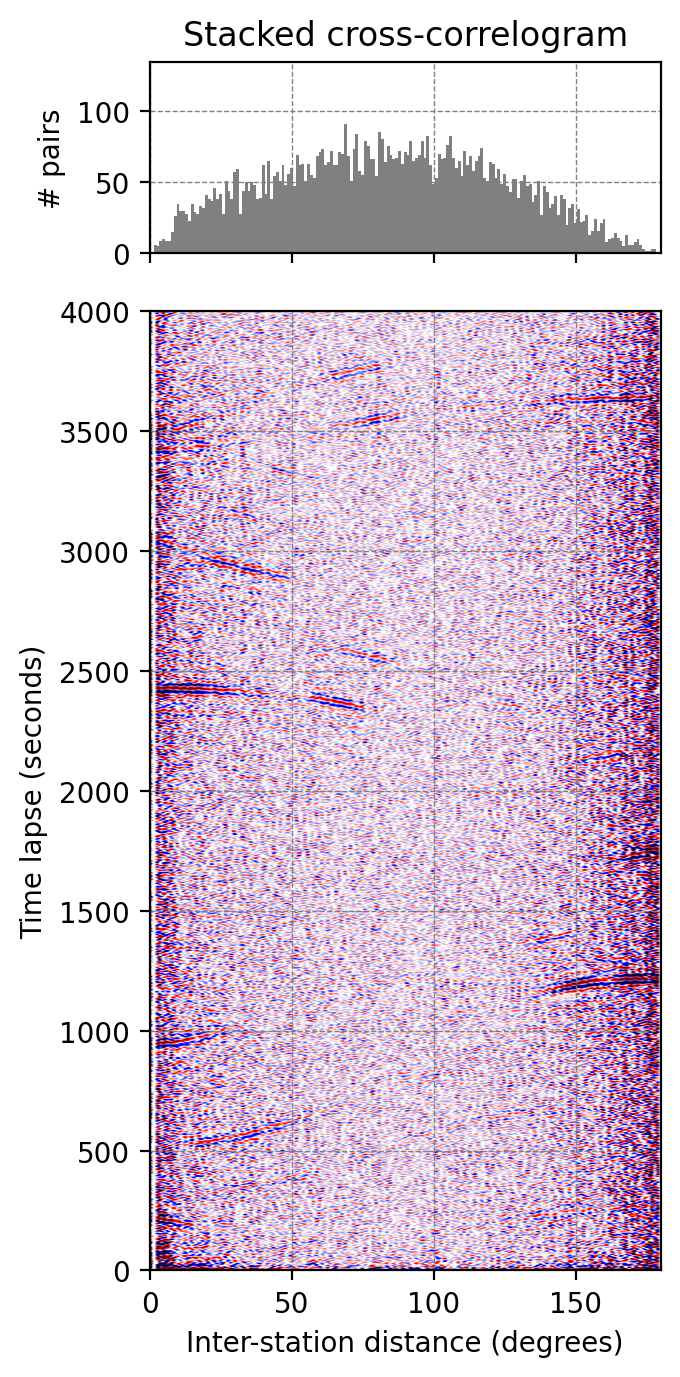

In [19]:
#@title Plot the stacked cross-correlogram
#@markdown This cell with will stack all the submited correlogram and display the result.

def stack_correlograms(fname_list):
    """
    Stack the cross-correlograms from the given list of files.
    """
    # load the correlograms
    fname_list = list(fname_list)
    correlograms = [pickle.load(open(fname, 'rb')) for fname in fname_list]
    # display the individual correlogram
    # for fname in fname_list: display_correlogram_plain(fname, filter_kw, fname=str(fname).replace('.pkl', '.png'))
    # for i, c in enumerate(correlograms):
    #     print (fname_list[i], c.keys())
    # get the number of bins and time lags
    bin_count = np.sum([c['bin_count'] for c in correlograms], axis=0)
    image = np.sum([c['image'] for c in correlograms], axis=0)

    output = correlograms[0].copy()
    output['bin_count'] = bin_count
    output['image'] = image
    return output

display_correlogram(stack_correlograms(XCORR_path.glob('*.pkl')), filter_kw, title='Stacked cross-correlogram')

---
## Conclusions
- The data processing presented in this notebook turns noisy data into valuable insights into the Earth's deep interior.
- This framework has enabled several discoveries of the deep Earth and planetary interiors at the ANU Global seismology group.

---
## Bonus project

Hello, thank you for being interested in the bonus project. Although everyone is encouraged to complete bonus projects, undergrad students will be considered for bonus points to their final exams. Best of luck!

*In this project, you are asked to write a small piece of code to compile the list of all ISC event ids for M > 7.0 in year 2015, compute their single-event correlograms, and finally display the stacked correlograms.*

If you submit a working code towards completing the task, you will get 50% points. If the code produces correct outcome, you will get 75%. The minimal two-paragraphs on the motivation and additional thoughts will get you to 100%.

Please submit this jupyter notebook to the following form: https://forms.gle/L5QLLYMEnm277bTMA.

In [20]:
#@title Click for hint

## Uncomment the code to retrieve the ISC event IDs for event of magnitudes>7.5 in year 2015.
cat2015 = Client('ISC').get_events(starttime=UTCDateTime(2015, 1, 1), endtime=UTCDateTime(2015, 12, 31),
    minmagnitude=7.5, maxmagnitude=10.0)
isc_eventid_2015 = [ev.resource_id.id.split('=')[-1] for ev in cat2015]
print (isc_eventid_2015)

## Interatively compute individual event correlograms.
corr_fname_2015 = []
for isc_eventid in isc_eventid_2015:
    # Fetch the event information
    event = get_event(isc_eventid)
    corr_fname = XCORR_path/event.preferred_origin().time.strftime('XC.%Y%m%d.pkl')
    corr_fname_2015.append(corr_fname)
    if corr_fname.exists():
        print (f'File {corr_fname} already exists. Skipping ...'); continue
    print (f'Processing event {isc_eventid} ...')

    ## ENTER YOUR CODE HERE

## Stack the computed correlograms and plot the result.
## ENTER YOUR CODE HERE

['610587229', '607208674', '607744335', '610588278', '611531714', '608081959']
Processing event 610587229 ...
Processing event 607208674 ...
Processing event 607744335 ...
Processing event 610588278 ...
Processing event 611531714 ...
Processing event 608081959 ...
